<h1><b>Transcribing audio file using Google Cloud Speech</b></h1>

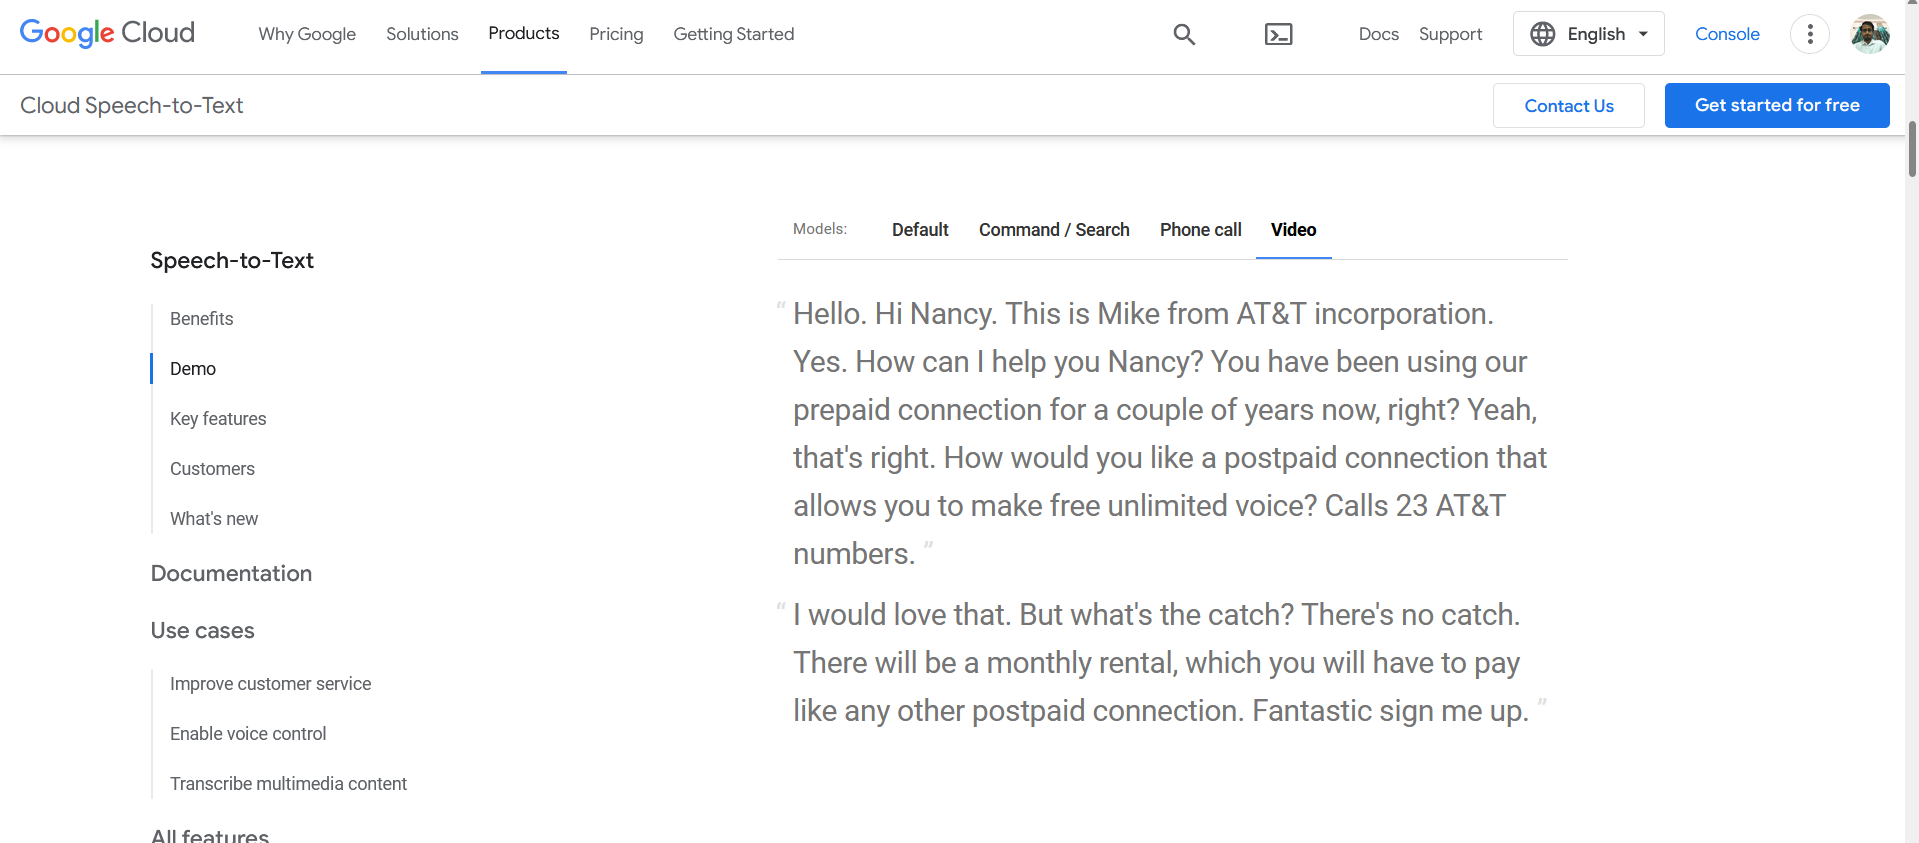

In [ ]:
#Converting text to string
txt='''Hello. Hi Nancy. This is Mike from AT&T incorporation.
Yes. How can I help you Nancy? You have been using our
prepaid connection for a couple of years now, right? Yeah,
that's right. How would you like a postpaid connection that
allows you to make free unlimited voice? Calls 23 AT&T
numbers. I would love that. But what's the catch? There's no catch.
There will be a monthly rental, which you will have to pay
like any other postpaid connection. Fantastic sign me up.'''

<h1><b>Creating a dataset for training NLU model</b></h1>

In [ ]:
#Using spaCy cli to download large library
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
#Loading the library
import spacy
nlp=spacy.load('en_core_web_lg')

In [ ]:
#Reading the .txt file 
with open('One Up on Wall Street (Peter Lynch) (z-lib.org).txt','r') as f:
  book=f.read()

#Taking the max size of the string for tokenization
book=book[:1000000]

In [ ]:
#Tokenizing the book
book=nlp(book)

In [ ]:
#Removing stopwords and punctuations
words=[word.text for word in book if not word.is_punct if not word.is_stop]

In [ ]:
#Converting words to strings
words=[str(word) for word in words]

In [ ]:
#Converting words into lowercase
words=[word.lower() for word in words]

In [ ]:
#Removing blank lines
words=[word for word in words if word not in ['\n',' ','\n\n']]

In [ ]:
#Removing blank spaces from words
words=[word.strip() for word in words]

In [ ]:
#Removing blank lines
import re
words=" ".join(words)
words=re.sub('\n','',words)

In [ ]:
words=nlp(words)

<b>Creating the dataframe</b>

In [ ]:
#Creating a dictionary
df=dict()

for word in words.ents:
  if word.text not in df.keys():


    #Words are the features, the entity name is the label
    df[word.text]=word.label_

In [ ]:
#Dataset
data={'word':df.keys(),'entity':df.values()}

In [ ]:
#Creating the dictionary to Dataframe
import pandas as pd
data=pd.DataFrame(data)

In [ ]:
data.head()

,word,entity
0,peter ae,PERSON
1,peter lynch america,ORG
2,90s,DATE
3,daily,DATE
4,multibillion dollar,MONEY


<b>Data Preprocessing</b>

In [ ]:
data['entity'].unique()

array(['PERSON', 'ORG', 'DATE', 'MONEY', 'GPE', 'CARDINAL', 'TIME',
       'QUANTITY', 'WORK_OF_ART', 'LAW', 'PERCENT', 'LOC', 'ORDINAL',
       'EVENT', 'NORP', 'PRODUCT', 'FAC'], dtype=object)

In [ ]:
#Finding null values
data.isnull().sum()

word      0
entity    0
dtype: int64

In [ ]:
data['entity'].value_counts()


CARDINAL       745
ORG            686
DATE           446
MONEY          409
PERSON         369
PERCENT        120
GPE             99
QUANTITY        41
TIME            30
NORP            29
PRODUCT         29
LAW              9
LOC              8
FAC              7
ORDINAL          7
EVENT            3
WORK_OF_ART      1
Name: entity, dtype: int64

In [ ]:
#Removing rows with unimportant and low frequency labels
data_sub=data[data['entity'].isin(['NORP','QUANTITY','WORK_OF_ART','LAW','FAC','LOC','EVENT','ORDINAL','CARDINAL'])].index

In [ ]:
data.drop(data_sub,inplace=True)

In [ ]:
data['entity'].value_counts()

ORG        686
DATE       446
MONEY      409
PERSON     369
PERCENT    120
GPE         99
TIME        30
PRODUCT     29
Name: entity, dtype: int64

There seems to be an imbalance in the data.

In [ ]:
#Splitting dataset by labels

data_per=data[data['entity']=='PERSON']

data_date=data[data['entity']=='DATE']

data_org=data[data['entity']=='ORG']

data_time=data[data['entity']=='TIME']

data_gpe=data[data['entity']=='GPE']

data_prod=data[data['entity']=='PRODUCT']

data_ord=data[data['entity']=='ORDINAL']

In [ ]:
#Oversampling the data to reduce imbalance

data_date_over = data_per.sample(686, replace=True)

data_time_over = data_per.sample(686, replace=True)

data_person_over = data_per.sample(686, replace=True)

data_gpe_over = data_per.sample(686, replace=True)

data_prod_over = data_per.sample(686, replace=True)

data_ord_over = data_per.sample(686, replace=True)


In [ ]:
#Merging the processed data
oversampled_data=pd.concat([data_org,data_date_over,data_time_over,data_person_over,
                            data_gpe_over,data_prod_over,data_ord_over],axis=0)

In [ ]:
oversampled_data.shape

(4802, 2)

In [ ]:
#Splitting data into training and testing data
from sklearn.model_selection import train_test_split

X = data['word']  
y = data['entity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#Using Tfidf Vectorizer to convert strings to numerical variables
from sklearn.feature_extraction.text import TfidfVectorizer


#Using SVM classifier to separate the data
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [ ]:
# Report the confusion matrix
from sklearn import metrics


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

        DATE       0.88      0.83      0.85       157
         GPE       0.43      0.08      0.14        37
       MONEY       0.86      0.71      0.78       130
         ORG       0.62      0.92      0.74       222
     PERCENT       0.87      0.92      0.89        36
      PERSON       0.89      0.64      0.75       123
     PRODUCT       1.00      0.23      0.38        13
        TIME       1.00      0.40      0.57         5

    accuracy                           0.76       723
   macro avg       0.82      0.59      0.64       723
weighted avg       0.78      0.76      0.74       723



<h1><b>Using the model on the transcribed text</b></h1>

In [ ]:
txt='''Hello. Hi Nancy. This is Mike from AT&T incorporation. Yes. How can I help you Nancy? You have been using our prepaid connection for a couple of years now, right? Yeah, that's right. How would you like a postpaid connection that allows you to make free unlimited voice? Calls 23 AT&T numbers. I would love that. But what's the catch? There's no catch. There will be a monthly rental, which you will have to pay like any other postpaid connection. Fantastic sign me up.'''

In [ ]:
txt

"Hello. Hi Nancy. This is Mike from AT&T incorporation. Yes. How can I help you Nancy? You have been using our prepaid connection for a couple of years now, right? Yeah, that's right. How would you like a postpaid connection that allows you to make free unlimited voice? Calls 23 AT&T numbers. I would love that. But what's the catch? There's no catch. There will be a monthly rental, which you will have to pay like any other postpaid connection. Fantastic sign me up."

In [ ]:
txt=nlp(txt)

In [ ]:
#To store the file
dc=dict()

In [ ]:
#Creating the JSON file
i=1
for token in txt.sents:
  line=token
  name=[]
  org=[]
  id='task_'+str(i)+'_output'
  i=i+1
  dc[id]=dict()
  dc[id]['sentence']=line
  for word in line.ents:
    if word.ents:
      name.append(word.text)
      org.append(text_clf.predict([word.text])[0])
  dc[id]['entities']=dict()
  dc[id]['entities']['entity_name']=name
  dc[id]['entities']['entity_value']=org
  


In [ ]:
dc

{'task_10_output': {'entities': {'entity_name': [], 'entity_value': []},
  'sentence': I would love that.},
 'task_11_output': {'entities': {'entity_name': [], 'entity_value': []},
  'sentence': But what's the catch?},
 'task_12_output': {'entities': {'entity_name': [], 'entity_value': []},
  'sentence': There's no catch.},
 'task_13_output': {'entities': {'entity_name': ['monthly'],
   'entity_value': ['ORG']},
  'sentence': There will be a monthly rental, which you will have to pay like any other postpaid connection.},
 'task_14_output': {'entities': {'entity_name': [], 'entity_value': []},
  'sentence': Fantastic sign me up.},
 'task_1_output': {'entities': {'entity_name': [], 'entity_value': []},
  'sentence': Hello.},
 'task_2_output': {'entities': {'entity_name': ['Nancy'],
   'entity_value': ['ORG']},
  'sentence': Hi Nancy.},
 'task_3_output': {'entities': {'entity_name': ['Mike', 'AT&T'],
   'entity_value': ['PERSON', 'ORG']},
  'sentence': This is Mike from AT&T incorporation

In [ ]:
#Save as JSON file
import json
with open('output.json','w') as f:
  f1=json.dumps(str(dc),indent=6)
  f.write(f1)
f.close()